In [1]:
import platform

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import seaborn as sns
sns.set(style="darkgrid")

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,6]

In [2]:
df = pd.read_csv('data/card_data.csv', encoding='EUC-KR')
# df.head()

In [3]:
df_upjong = pd.read_csv('data/card_data_upjong.csv', encoding='EUC-KR')
# df_upjong.head()

##### SB_UPJONG_CD 소문자 -> 대문자

In [4]:
df_upjong=df_upjong.applymap(str.upper)

In [5]:
# df_upjong

##### Data 결합(Left Join) : card_data에 업종 대분류, 중분류, 소분류 이름 추가

In [6]:
df_merge_col = pd.merge(df,df_upjong,on='SB_UPJONG_CD',how='left')

In [7]:
# df_merge_col

In [8]:
del df_merge_col['BLCK_CD']  # 사용 안하는 데이터 삭제

In [9]:
# df_merge_col

In [10]:
# data 분석을 위한 칼럼 신규 추가
# 1. 사용시간 구분
# 새벽 : 00시~06시 / 오전 : 06시~11시 / 점심 : 11시~13시 / 오후 : 13시~18시 / 저녁 : 18시~24시
used_time = []

for idx in df_merge_col['TM']:
    if idx >= 18:
        used_time.append('5.저녁')
    elif idx >= 13:
        used_time.append('4.오후')
    elif idx >= 11:
        used_time.append('3.점심')
    elif idx >= 6:
        used_time.append('2.오전')
    else:
        used_time.append('1.새벽')
df_merge_col['used_time'] = used_time
# df_merge_col

In [11]:
# data 분석을 위한 칼럼 신규 추가
# 2. 요일 정렬
DAW_N = []

for idx in range(len(df_merge_col['DAW'])):
    if df_merge_col['DAW'][idx] == '월요일':
        DAW_N.append('1.월요일')
    elif df_merge_col['DAW'][idx] == '화요일':
        DAW_N.append('2.화요일')        
    elif df_merge_col['DAW'][idx] == '수요일':
        DAW_N.append('3.수요일')        
    elif df_merge_col['DAW'][idx] == '목요일':
        DAW_N.append('4.목요일')        
    elif df_merge_col['DAW'][idx] == '금요일':
        DAW_N.append('5.금요일')        
    elif df_merge_col['DAW'][idx] == '토요일':
        DAW_N.append('6.토요일')                
    else:
        DAW_N.append('7.일요일')
        
df_merge_col['DAW_N'] = DAW_N
# df_merge_col

##### 결측치 확인 -> 없음

In [12]:
df_merge_col.isnull().sum()

SB_UPJONG_CD      0
TS_YM             0
TS_YMD            0
DAW               0
TM                0
AMT_CORR          0
USECT_CORR        0
SB_L_UPJONG_NM    0
SB_M_UPJONG_NM    0
SB_UPJONG_NM      0
used_time         0
DAW_N             0
dtype: int64

## 대분류 업종별 카드사용 금액
- 사용금액 합계 높은 업종에 대한 월별 카드사용액 추이 분석

In [13]:
df_L_sum=Series(df_merge_col.groupby('SB_L_UPJONG_NM')['AMT_CORR'].sum())

Text(0.5, 1.0, '\n 업종 대분류별 카드사용액 합계 \n')

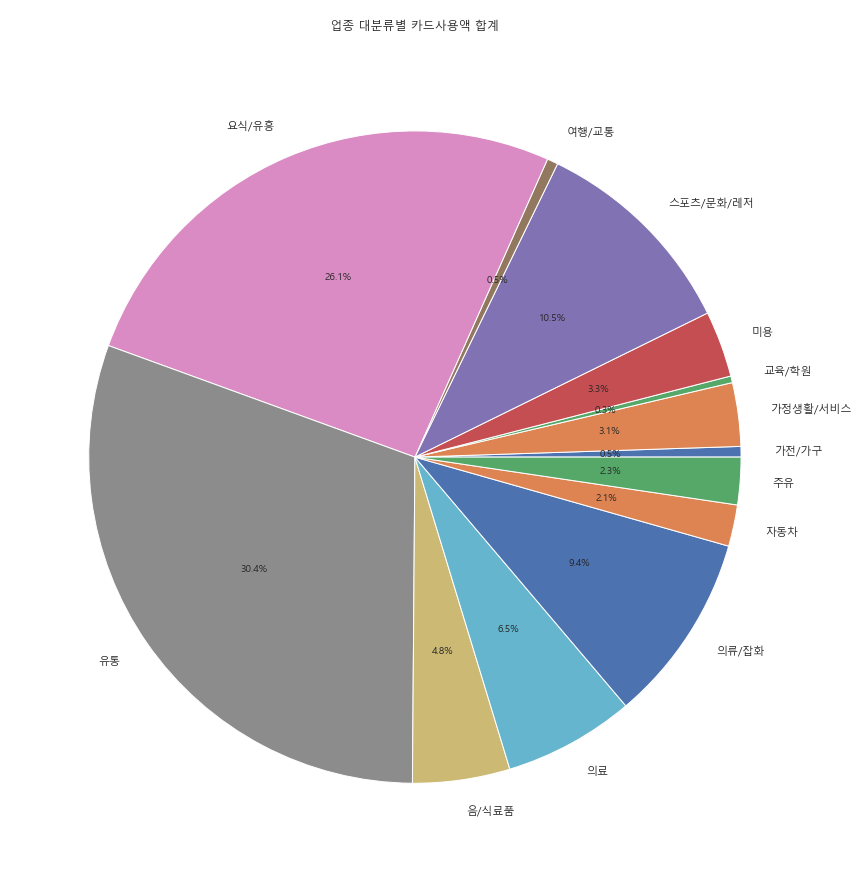

In [14]:
plt.rcParams["figure.figsize"] = [15,15]
plt.pie(df_L_sum, labels = df_L_sum.index, autopct = '%.1f%%')
plt.title('\n 업종 대분류별 카드사용액 합계 \n')

## 문자열인 TS_YM Date 객체로 변환
- 월별 분석 위함

In [15]:
df_merge_col['TS_YM'] = pd.to_datetime(df['TS_YM'], format='%Y%m') 
# df_merge_col.head(10)

In [16]:
df_merge_col.set_index('TS_YM', inplace=True)       
# df_merge_col.head()

In [17]:
df_merge_col['TS_M'] = df_merge_col.index.month
# df_merge_col.head(10)

## 대분류=유통 조건문으로 행 추출

In [18]:
df_Utong_col = df_merge_col[df_merge_col['SB_L_UPJONG_NM']=='유통']

In [19]:
df_Utong_sum = df_Utong_col.groupby('SB_UPJONG_NM')['AMT_CORR'].sum()

Text(0.5, 1.0, '\n 유통업 소분류 카드사용액 합계 \n')

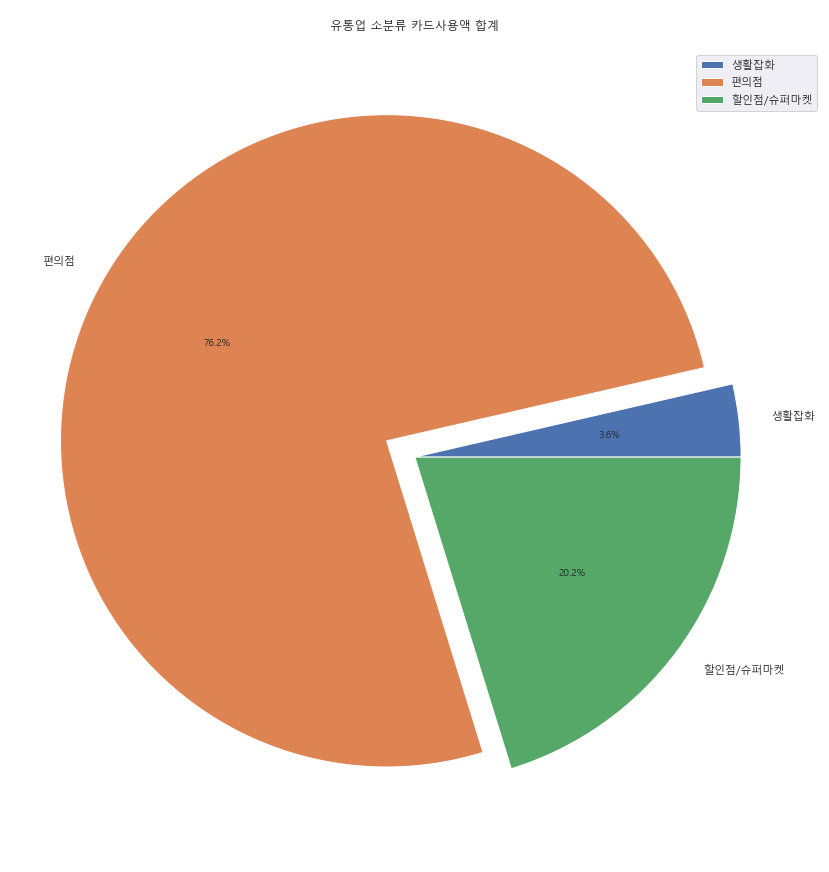

In [20]:
plt.rcParams["figure.figsize"] = [15,15]
explode = [0,0.1,0]
plt.pie(df_Utong_sum, explode=explode, labels = df_Utong_sum.index, autopct = '%.1f%%')
plt.legend(df_Utong_sum.index[:], loc=1)
plt.title('\n 유통업 소분류 카드사용액 합계 \n')

## 월별 유통업 소분류별 사용금액

In [21]:
df_Utong_col = df_Utong_col[['SB_UPJONG_NM','TS_M','AMT_CORR']]
# df_Utong_col

In [22]:
temp_df = df_Utong_col.groupby(["TS_M","SB_UPJONG_NM"]).sum().unstack(1)
temp_df = temp_df.fillna(0)
temp_df = temp_df['AMT_CORR']
# temp_df

In [23]:
X  = list(temp_df.index)
Y1 = list(temp_df['편의점'])
Y2 = list(temp_df['할인점/슈퍼마켓'])
Y3 = list(temp_df['생활잡화'])

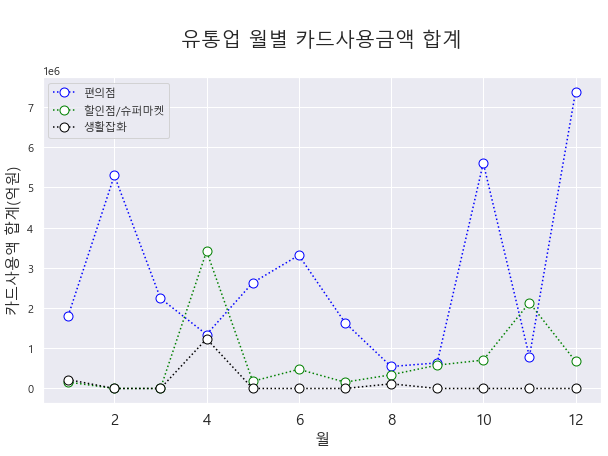

In [24]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '편의점')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '할인점/슈퍼마켓')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '생활잡화')
plt.xlabel('월', fontsize = 15)
plt.ylabel('카드사용액 합계(억원)', fontsize = 15)
plt.title('\n유통업 월별 카드사용금액 합계\n', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

## 대분류=요식/유흥 조건문으로 행 추출

In [25]:
df_YU_col = df_merge_col[df_merge_col['SB_L_UPJONG_NM']=='요식/유흥']

In [26]:
df_YU_col[['SB_UPJONG_CD','AMT_CORR','SB_UPJONG_NM','TS_M']]

,SB_UPJONG_CD,AMT_CORR,SB_UPJONG_NM,TS_M
TS_YM,,,,
2019-06-01,SB001,58851.0,한식,6
2017-11-01,SB007,21629.0,패스트푸드,11
2017-06-01,SB006,181080.0,커피전문점,6
2021-05-01,SB005,264578.0,제과점,5
2017-08-01,SB006,326044.6,커피전문점,8
...,...,...,...,...
2020-10-01,SB001,7545.0,한식,10
2019-03-01,SB002,228865.0,일식,3
2018-05-01,SB008,161966.0,기타요식,5


In [27]:
df_YU_sum = df_YU_col.groupby('SB_UPJONG_NM')['AMT_CORR'].sum()

Text(0.5, 1.0, '\n 요식/유흥업 소분류 카드사용액 합계 \n')

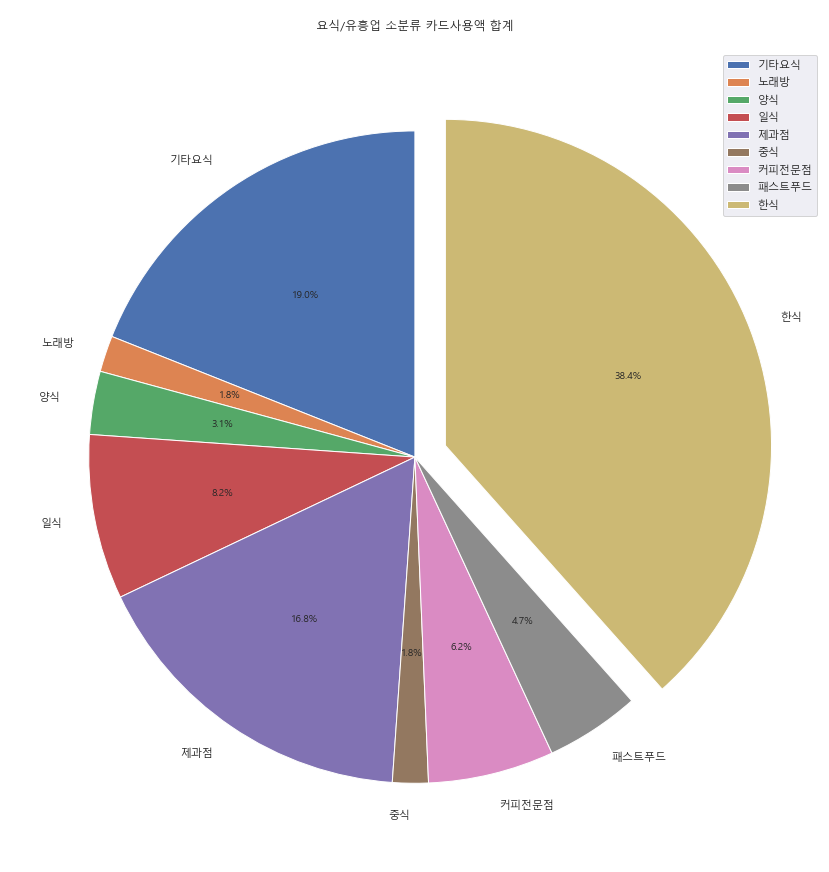

In [28]:
plt.rcParams["figure.figsize"] = [15,15]
explode = [0,0,0,0,0,0,0,0,0.1]
plt.pie(df_YU_sum, labels = df_YU_sum.index, autopct = '%.1f%%', explode=explode, startangle=90)
plt.legend(df_YU_sum.index[:], loc=1)
plt.title('\n 요식/유흥업 소분류 카드사용액 합계 \n')

## 월별 요식/유흥업 소분류별 사용금액

In [29]:
df_YU_col = df_YU_col[['SB_UPJONG_NM','TS_M','AMT_CORR']]

In [30]:
temp_df1 = df_YU_col.groupby(["TS_M","SB_UPJONG_NM"]).sum().unstack(1)
temp_df1 = temp_df1.fillna(0)
temp_df1 = temp_df1['AMT_CORR']
# temp_df1

In [31]:
X  = list(temp_df1.index)
Y1 = list(temp_df1['한식'])
# Y2 = list(temp_df1['기타요식'])
Y3 = list(temp_df1['제과점'])
Y4 = list(temp_df1['일식'])
Y5 = list(temp_df1['커피전문점'])

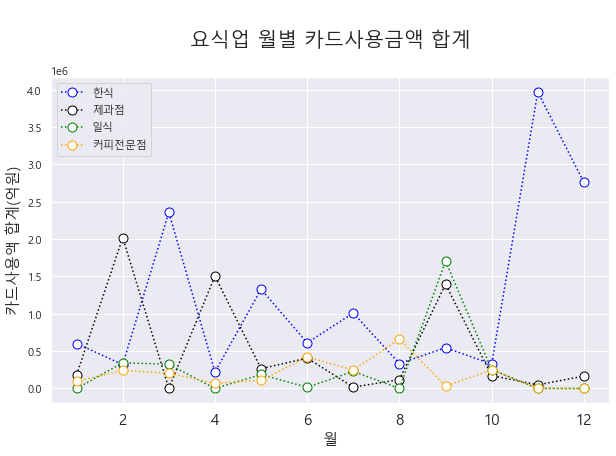

In [32]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '한식')
# plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
#         markersize = 9, label = '기타/요식')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '제과점')
plt.plot(X, Y4, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '일식')
plt.plot(X, Y5, color = 'orange', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '커피전문점')
plt.xlabel('월', fontsize = 15)
plt.ylabel('카드사용액 합계(억원)', fontsize = 15)
plt.title('\n요식업 월별 카드사용금액 합계\n', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

## pyplog.subplot : 1page report

In [33]:
def draw_pieplot(param):

    if param == '대분류':
        plt.rcParams["figure.figsize"] = [15,15]
        plt.pie(df_L_sum, labels = df_L_sum.index, autopct = '%.1f%%')
        plt.title('\n 업종 대분류별 카드사용액 합계 \n')
    elif param == '유통업':
        plt.rcParams["figure.figsize"] = [15,15]
        explode = [0,0.1,0]
        plt.pie(df_Utong_sum, explode=explode, labels = df_Utong_sum.index, autopct = '%.1f%%')
        plt.legend(df_Utong_sum.index[:], loc=1)
        plt.title('\n 유통업 소분류 카드사용액 합계 \n')
    elif param == '요식/유흥':
        plt.rcParams["figure.figsize"] = [15,15]
        explode = [0,0,0,0,0,0,0,0,0.1]
        plt.pie(df_YU_sum, labels = df_YU_sum.index, autopct = '%.1f%%', explode=explode, startangle=90)
        plt.legend(df_YU_sum.index[:], loc=1)
        plt.title('\n 요식/유흥업 소분류 카드사용액 합계 \n')

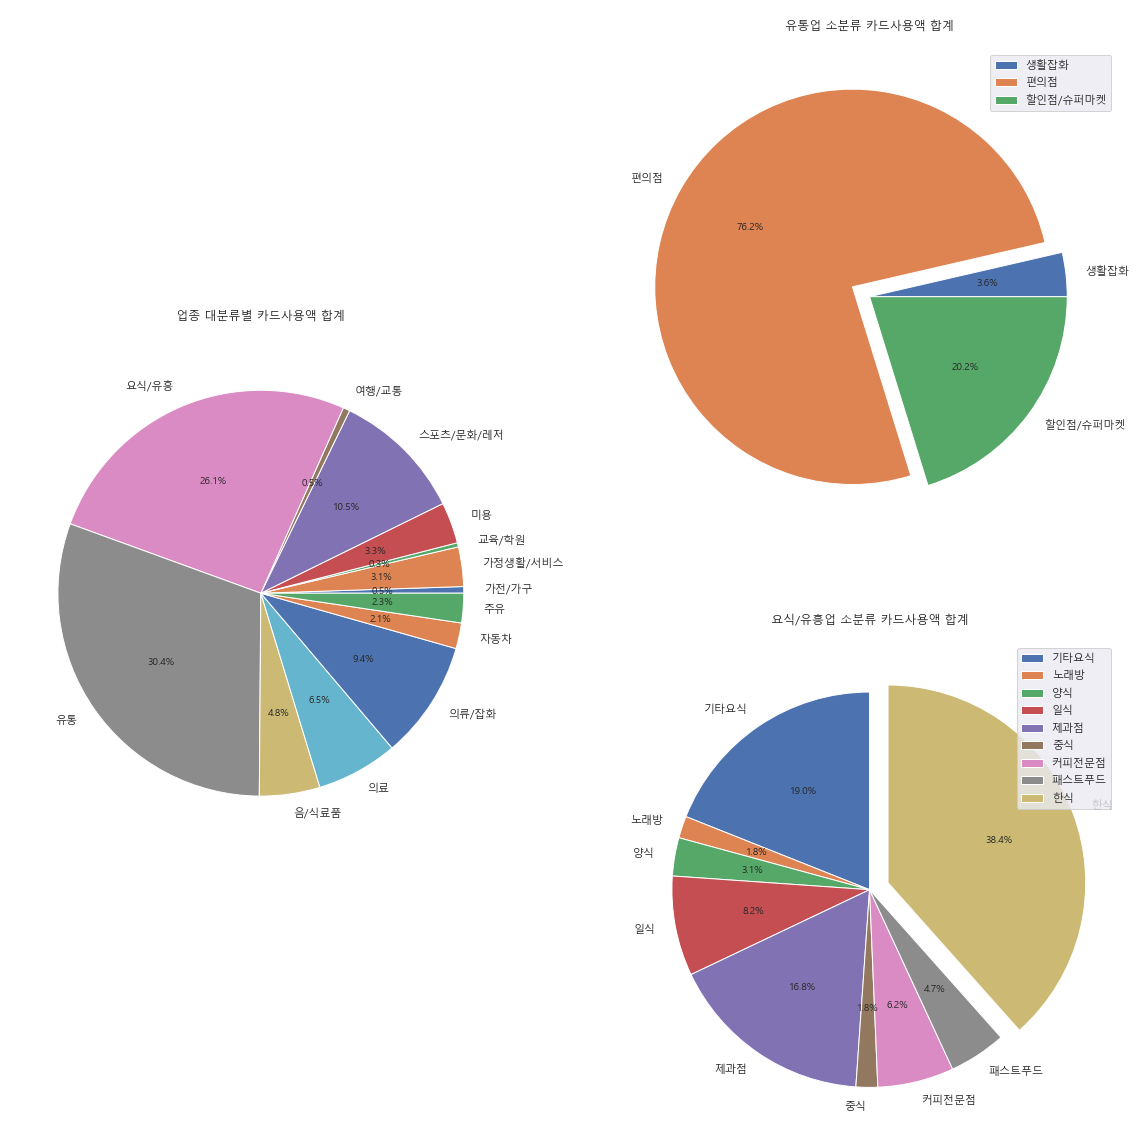

In [34]:
plt.figure(figsize=(20,20))

plt.subplot(121)
draw_pieplot('대분류')

plt.subplot(222) 
draw_pieplot('유통업')

plt.subplot(224)
draw_pieplot('요식/유흥')

plt.show()

## 대분류 업종별 카드사용 건수
- 사용건수 합계 높은 업종에 대한 일별 / 시간별 카드사용건 추이 분석

In [35]:
from datetime import datetime
import seaborn as sns
sns.set(style="darkgrid")

In [36]:
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/MALGUN.TTF").get_name()
rc('font', family=font_name)

plt.rcParams['figure.figsize'] = (12,8)

In [37]:
obj = df_merge_col.groupby('SB_L_UPJONG_NM').sum()
obj = obj['USECT_CORR']
obj = obj.sort_values(ascending = False)
obj

SB_L_UPJONG_NM
요식/유흥        3094.60
유통           2414.59
의료            688.15
음/식료품         444.79
스포츠/문화/레저     323.11
미용            245.51
주유            134.85
의류/잡화         129.82
자동차           123.83
여행/교통          65.39
가정생활/서비스       60.36
교육/학원          55.33
가전/가구          40.24
Name: USECT_CORR, dtype: float64

In [38]:
obj['기타'] = obj[-7:-1].sum()
obj

SB_L_UPJONG_NM
요식/유흥        3094.60
유통           2414.59
의료            688.15
음/식료품         444.79
스포츠/문화/레저     323.11
미용            245.51
주유            134.85
의류/잡화         129.82
자동차           123.83
여행/교통          65.39
가정생활/서비스       60.36
교육/학원          55.33
가전/가구          40.24
기타            569.58
Name: USECT_CORR, dtype: float64

In [39]:
obj2 = obj.drop(['의류/잡화','자동차','여행/교통', '가정생활/서비스', '교육/학원', '가전/가구'])
obj2

SB_L_UPJONG_NM
요식/유흥        3094.60
유통           2414.59
의료            688.15
음/식료품         444.79
스포츠/문화/레저     323.11
미용            245.51
주유            134.85
기타            569.58
Name: USECT_CORR, dtype: float64

###### 의류/잡화, 자동차, 여행/교통, 가정생활/서비스, 교육/학원, 가전/가구업종 => '기타업종'으로 묶기

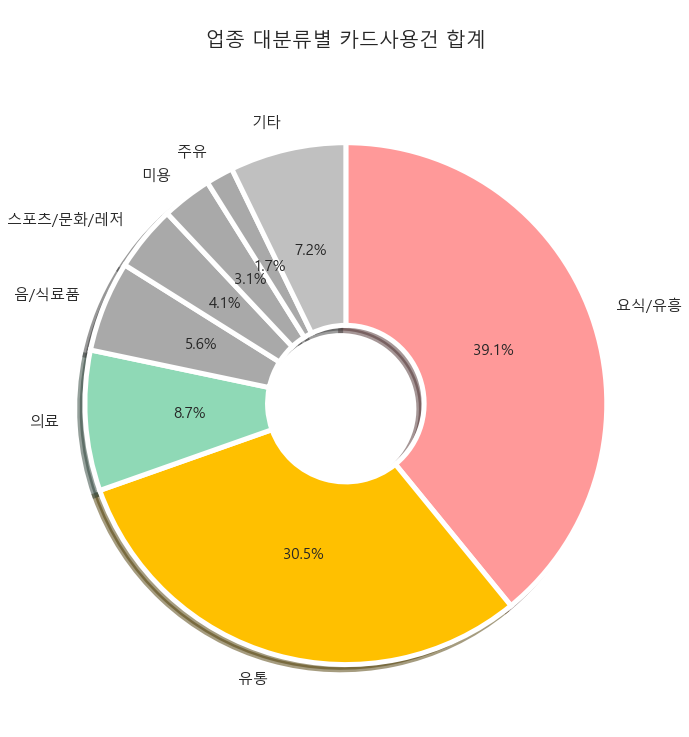

In [40]:
plt.rcParams["figure.figsize"] = [12,12]
colors = ['#ff9999','#ffc000','#8fd9b6','darkgray','darkgray','darkgray','darkgray','silver'] 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(obj2, labels = obj2.index, autopct = '%.1f%%', startangle = 90, counterclock=False,
        shadow = True, colors = colors, wedgeprops=wedgeprops, textprops={'fontsize': 15})
plt.title('\n 업종 대분류별 카드사용건 합계 \n', fontsize = 20)
plt.show()

### 개별분석) 카드사용건수 Top3 업종 (요식 / 유통 / 의료)

In [41]:
# 분석에 필요한 칼럼들만 추출
cnt_df = df_merge_col[['SB_L_UPJONG_NM','SB_M_UPJONG_NM','DAW_N','TM','USECT_CORR','used_time']]
cnt_df

,SB_L_UPJONG_NM,SB_M_UPJONG_NM,DAW_N,TM,USECT_CORR,used_time
TS_YM,,,,,,
2019-06-01,요식/유흥,한식,6.토요일,18,20.12,5.저녁
2017-11-01,요식/유흥,제과/커피/패스트푸드,5.금요일,1,10.06,1.새벽
2019-04-01,의료,약국,5.금요일,19,60.36,5.저녁
2017-12-01,미용,미용서비스,1.월요일,18,10.06,5.저녁
2017-04-01,유통,편의점,7.일요일,18,5.03,5.저녁
...,...,...,...,...,...,...
2017-03-01,유통,편의점,6.토요일,19,5.03,5.저녁
2018-04-01,음/식료품,음/식료품,1.월요일,14,5.03,4.오후
2021-06-01,유통,편의점,5.금요일,15,20.12,4.오후


In [42]:
# key값인 내국인업종코드 index로 지정
cnt_df2 = cnt_df.set_index(['SB_L_UPJONG_NM'])
cnt_df2.head()

,SB_M_UPJONG_NM,DAW_N,TM,USECT_CORR,used_time
SB_L_UPJONG_NM,,,,,
요식/유흥,한식,6.토요일,18,20.12,5.저녁
요식/유흥,제과/커피/패스트푸드,5.금요일,1,10.06,1.새벽
의료,약국,5.금요일,19,60.36,5.저녁
미용,미용서비스,1.월요일,18,10.06,5.저녁
유통,편의점,7.일요일,18,5.03,5.저녁


> Top1) 요식업종 - 시간대별

In [43]:
top1_df = cnt_df2.loc[['요식/유흥']]
top1_df

,SB_M_UPJONG_NM,DAW_N,TM,USECT_CORR,used_time
SB_L_UPJONG_NM,,,,,
요식/유흥,한식,6.토요일,18,20.12,5.저녁
요식/유흥,제과/커피/패스트푸드,5.금요일,1,10.06,1.새벽
요식/유흥,제과/커피/패스트푸드,6.토요일,19,5.03,5.저녁
요식/유흥,제과/커피/패스트푸드,2.화요일,20,174.13,5.저녁
요식/유흥,제과/커피/패스트푸드,1.월요일,12,5.03,3.점심
...,...,...,...,...,...
요식/유흥,한식,3.수요일,15,5.03,4.오후
요식/유흥,일식/중식/양식,2.화요일,16,5.03,4.오후
요식/유흥,기타요식,3.수요일,14,5.03,4.오후


In [44]:
pv1 = pd.pivot_table(top1_df, values = 'USECT_CORR', index = ['used_time'],
                     columns = ['SB_M_UPJONG_NM'], aggfunc = 'sum')
pv1

SB_M_UPJONG_NM,기타요식,유흥,일식/중식/양식,제과/커피/패스트푸드,한식
used_time,,,,,
1.새벽,10.06,NaN,NaN,30.18,70.42
2.오전,79.52,10.06,25.15,206.23,99.64
3.점심,180.12,NaN,49.34,75.45,30.18
4.오후,216.29,54.37,251.50,240.48,413.65
5.저녁,195.21,5.03,77.60,489.33,284.79


In [45]:
pv1.fillna(0) 

SB_M_UPJONG_NM,기타요식,유흥,일식/중식/양식,제과/커피/패스트푸드,한식
used_time,,,,,
1.새벽,10.06,0.00,0.00,30.18,70.42
2.오전,79.52,10.06,25.15,206.23,99.64
3.점심,180.12,0.00,49.34,75.45,30.18
4.오후,216.29,54.37,251.50,240.48,413.65
5.저녁,195.21,5.03,77.60,489.33,284.79


In [46]:
X  = list(pv1.index)
Y1 = list(pv1['기타요식'])
Y2 = list(pv1['유흥'])
Y3 = list(pv1['일식/중식/양식'])
Y4 = list(pv1['제과/커피/패스트푸드'])
Y5 = list(pv1['한식'])

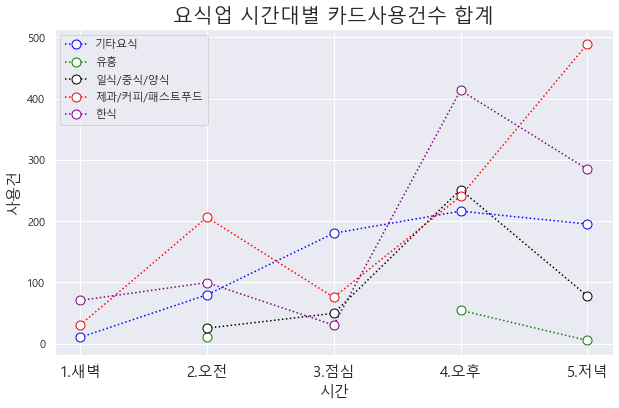

In [47]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '기타요식')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '유흥')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '일식/중식/양식')
plt.plot(X, Y4, color = 'red', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '제과/커피/패스트푸드')
plt.plot(X, Y5, color = 'purple', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '한식')
plt.xlabel('시간', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('요식업 시간대별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

> Top1) 요식업종 - 요일별

In [48]:
pv1 = pd.pivot_table(top1_df, values = 'USECT_CORR', index = ['DAW_N'],
                     columns = ['SB_M_UPJONG_NM'], aggfunc = 'sum')
pv1

SB_M_UPJONG_NM,기타요식,유흥,일식/중식/양식,제과/커피/패스트푸드,한식
DAW_N,,,,,
1.월요일,80.48,NaN,30.18,131.97,193.29
2.화요일,83.59,5.03,15.09,219.40,45.27
3.수요일,69.46,NaN,58.44,104.67,85.51
4.목요일,70.42,5.03,95.57,95.57,213.41
5.금요일,40.24,NaN,135.81,274.73,99.64
6.토요일,281.68,49.34,53.41,170.06,160.96
7.일요일,55.33,10.06,15.09,45.27,100.60


In [49]:
pv1.fillna(0)

SB_M_UPJONG_NM,기타요식,유흥,일식/중식/양식,제과/커피/패스트푸드,한식
DAW_N,,,,,
1.월요일,80.48,0.00,30.18,131.97,193.29
2.화요일,83.59,5.03,15.09,219.40,45.27
3.수요일,69.46,0.00,58.44,104.67,85.51
4.목요일,70.42,5.03,95.57,95.57,213.41
5.금요일,40.24,0.00,135.81,274.73,99.64
6.토요일,281.68,49.34,53.41,170.06,160.96
7.일요일,55.33,10.06,15.09,45.27,100.60


In [50]:
X  = list(pv1.index)
Y1 = list(pv1['기타요식'])
Y2 = list(pv1['유흥'])
Y3 = list(pv1['일식/중식/양식'])
Y4 = list(pv1['제과/커피/패스트푸드'])
Y5 = list(pv1['한식'])

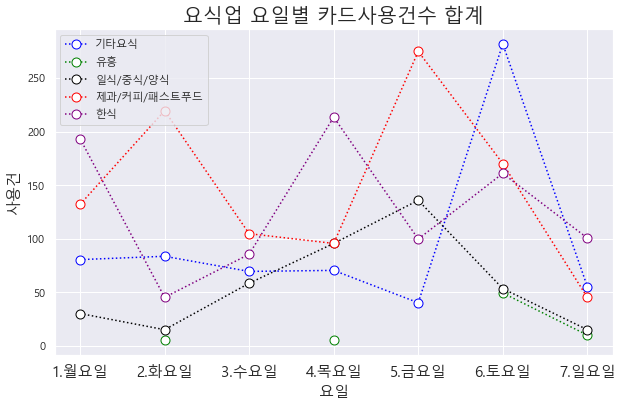

In [51]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '기타요식')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '유흥')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '일식/중식/양식')
plt.plot(X, Y4, color = 'red', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '제과/커피/패스트푸드')
plt.plot(X, Y5, color = 'purple', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '한식')
plt.xlabel('요일', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('요식업 요일별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

> Top2) 유통업종 - 시간대별

In [52]:
top2_df = cnt_df2.loc[['유통']]
top2_df

,SB_M_UPJONG_NM,DAW_N,TM,USECT_CORR,used_time
SB_L_UPJONG_NM,,,,,
유통,편의점,7.일요일,18,5.03,5.저녁
유통,할인점/슈퍼마켓,7.일요일,13,10.06,4.오후
유통,편의점,1.월요일,21,14.13,5.저녁
유통,편의점,6.토요일,17,20.12,4.오후
유통,편의점,4.목요일,9,5.03,2.오전
...,...,...,...,...,...
유통,편의점,7.일요일,12,15.09,3.점심
유통,할인점/슈퍼마켓,5.금요일,17,59.40,4.오후
유통,편의점,1.월요일,14,5.03,4.오후


In [53]:
pv2 = pd.pivot_table(top2_df, values = 'USECT_CORR', index = ['used_time'],
                     columns = ['SB_M_UPJONG_NM'], aggfunc = 'sum')
pv2 

SB_M_UPJONG_NM,편의점,할인점/슈퍼마켓
used_time,,
1.새벽,45.27,20.12
2.오전,291.24,29.22
3.점심,185.15,30.18
4.오후,772.70,205.27
5.저녁,642.15,193.29


In [54]:
pv2.fillna(0)

SB_M_UPJONG_NM,편의점,할인점/슈퍼마켓
used_time,,
1.새벽,45.27,20.12
2.오전,291.24,29.22
3.점심,185.15,30.18
4.오후,772.70,205.27
5.저녁,642.15,193.29


In [55]:
X  = list(pv2.index)
Y1 = list(pv2['편의점'])
Y2 = list(pv2['할인점/슈퍼마켓'])

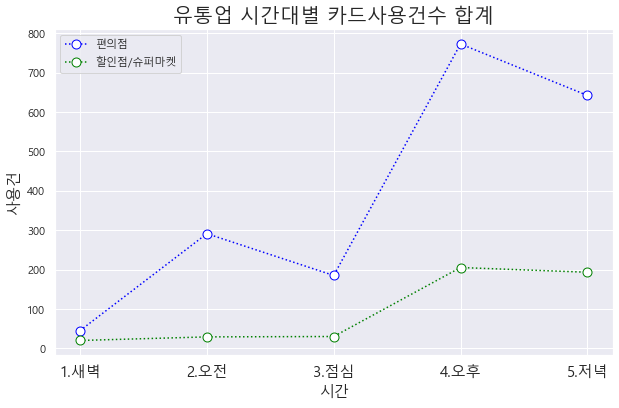

In [56]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '편의점')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '할인점/슈퍼마켓')
plt.xlabel('시간', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('유통업 시간대별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

> Top2) 유통업종 - 요일별

In [57]:
pv2 = pd.pivot_table(top2_df, values = 'USECT_CORR', index = ['DAW_N'],
                     columns = ['SB_M_UPJONG_NM'], aggfunc = 'sum')
pv2 

SB_M_UPJONG_NM,편의점,할인점/슈퍼마켓
DAW_N,,
1.월요일,250.54,39.28
2.화요일,114.73,104.67
3.수요일,512.10,NaN
4.목요일,246.47,125.75
5.금요일,351.37,109.70
6.토요일,325.49,88.62
7.일요일,135.81,10.06


In [58]:
pv2.fillna(0)

SB_M_UPJONG_NM,편의점,할인점/슈퍼마켓
DAW_N,,
1.월요일,250.54,39.28
2.화요일,114.73,104.67
3.수요일,512.10,0.00
4.목요일,246.47,125.75
5.금요일,351.37,109.70
6.토요일,325.49,88.62
7.일요일,135.81,10.06


In [59]:
X  = list(pv2.index)
Y1 = list(pv2['편의점'])
Y2 = list(pv2['할인점/슈퍼마켓'])

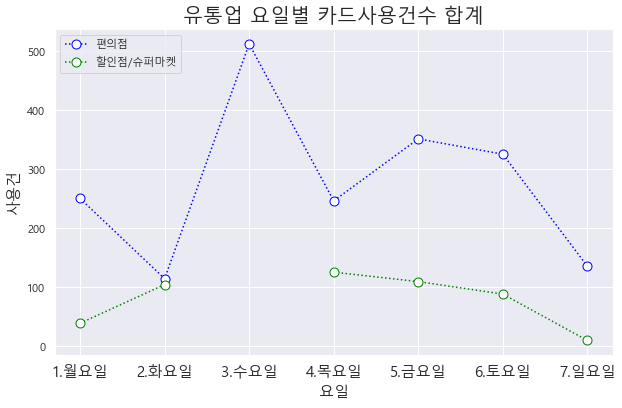

In [60]:
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '편의점')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '할인점/슈퍼마켓')
plt.xlabel('요일', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('유통업 요일별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

> Top3) 유통업종 - 시간대별

In [61]:
top3_df = cnt_df2.loc[['의료']]
top3_df.head()

,SB_M_UPJONG_NM,DAW_N,TM,USECT_CORR,used_time
SB_L_UPJONG_NM,,,,,
의료,약국,5.금요일,19,60.36,5.저녁
의료,병원,4.목요일,19,5.03,5.저녁
의료,병원,5.금요일,0,15.09,1.새벽
의료,병원,6.토요일,9,5.03,2.오전
의료,병원,6.토요일,14,5.03,4.오후


In [62]:
pv3 = pd.pivot_table(top3_df, values = 'USECT_CORR', index = ['used_time'],
                     columns = ['SB_M_UPJONG_NM'], aggfunc = 'sum')
pv3

SB_M_UPJONG_NM,기타의료,병원,약국
used_time,,,
1.새벽,NaN,15.09,85.51
2.오전,NaN,25.15,44.31
3.점심,NaN,35.21,70.42
4.오후,15.09,155.93,95.57
5.저녁,NaN,55.33,90.54


In [63]:
pv3.fillna(0)

SB_M_UPJONG_NM,기타의료,병원,약국
used_time,,,
1.새벽,0.00,15.09,85.51
2.오전,0.00,25.15,44.31
3.점심,0.00,35.21,70.42
4.오후,15.09,155.93,95.57
5.저녁,0.00,55.33,90.54


In [64]:
X  = list(pv3.index)
Y1 = list(pv3['기타의료'])
Y2 = list(pv3['병원'])
Y3 = list(pv3['약국'])

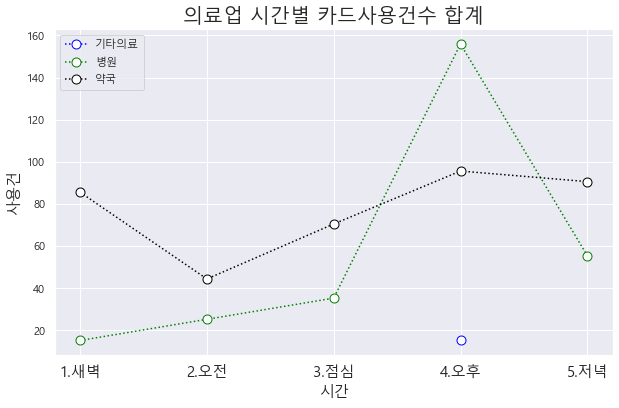

In [65]:
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '기타의료')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '병원')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '약국')
plt.xlabel('시간', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('의료업 시간별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

> Top3) 유통업종 - 요일별

In [66]:
pv3 = pd.pivot_table(top3_df, values = 'USECT_CORR', index = ['DAW_N'],
                     columns = ['SB_M_UPJONG_NM'], aggfunc = 'sum')
pv3 

SB_M_UPJONG_NM,기타의료,병원,약국
DAW_N,,,
1.월요일,NaN,90.54,15.09
2.화요일,15.09,5.03,69.46
3.수요일,NaN,15.09,70.42
4.목요일,NaN,35.21,20.12
5.금요일,NaN,30.18,75.45
6.토요일,NaN,50.30,45.27
7.일요일,NaN,60.36,90.54


In [67]:
pv3.fillna(0)

SB_M_UPJONG_NM,기타의료,병원,약국
DAW_N,,,
1.월요일,0.00,90.54,15.09
2.화요일,15.09,5.03,69.46
3.수요일,0.00,15.09,70.42
4.목요일,0.00,35.21,20.12
5.금요일,0.00,30.18,75.45
6.토요일,0.00,50.30,45.27
7.일요일,0.00,60.36,90.54


In [68]:
X  = list(pv3.index)
Y1 = list(pv3['기타의료'])
Y2 = list(pv3['병원'])
Y3 = list(pv3['약국'])

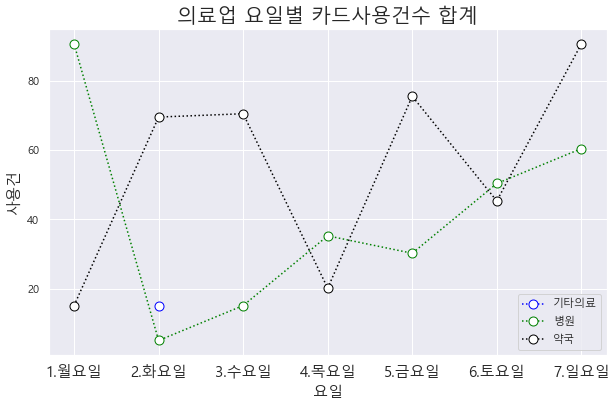

In [69]:
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '기타의료')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '병원')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '약국')
plt.xlabel('요일', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('의료업 요일별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 4)
plt.xticks(fontsize = 15)
plt.show()

# 최종결과

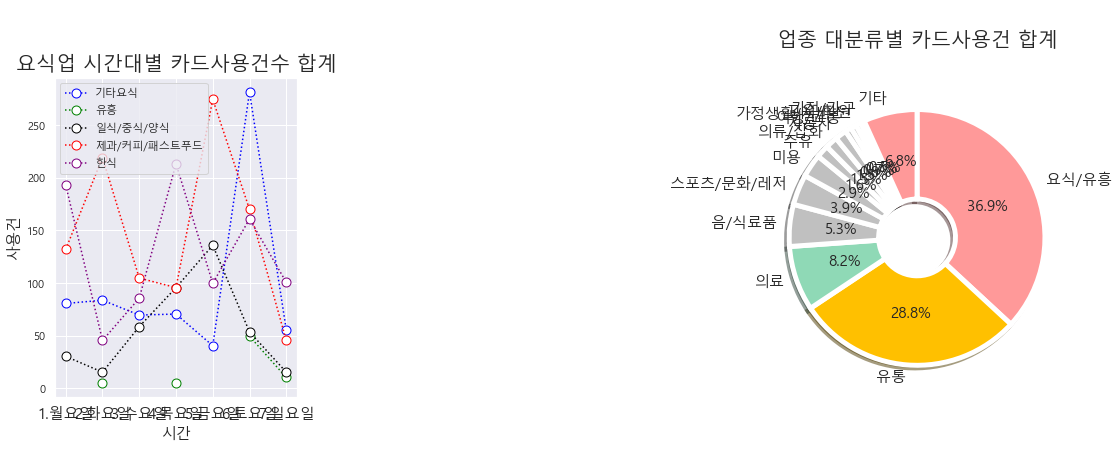

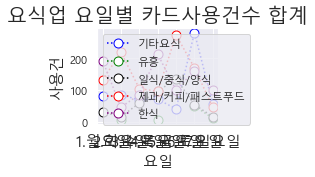

In [70]:
plt.figure(figsize = (20,20))

# 1
plt.subplot(322)
plt.title('\n 업종 대분류별 카드사용건 합계 \n', fontsize = 20)
colors = ['#ff9999','#ffc000','#8fd9b6','silver','silver','silver','silver','silver',
          'silver','silver','silver','silver','silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(obj, labels = obj.index, autopct = '%.1f%%', startangle = 90, counterclock=False,
        shadow = True, colors = colors, wedgeprops=wedgeprops, textprops={'fontsize': 15})

# 2
plt.subplot(341)
X  = list(pv1.index)
Y1 = list(pv1['기타요식'])
Y2 = list(pv1['유흥'])
Y3 = list(pv1['일식/중식/양식'])
Y4 = list(pv1['제과/커피/패스트푸드'])
Y5 = list(pv1['한식'])

plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '기타요식')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '유흥')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '일식/중식/양식')
plt.plot(X, Y4, color = 'red', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '제과/커피/패스트푸드')
plt.plot(X, Y5, color = 'purple', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '한식')
plt.xlabel('시간', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('요식업 시간대별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

# 3
plt.subplot(342)
X  = list(pv1.index)
Y1 = list(pv1['기타요식'])
Y2 = list(pv1['유흥'])
Y3 = list(pv1['일식/중식/양식'])
Y4 = list(pv1['제과/커피/패스트푸드'])
Y5 = list(pv1['한식'])

plt.rcParams['figure.figsize'] = (10,6)
plt.plot(X, Y1, color = 'blue', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '기타요식')
plt.plot(X, Y2, color = 'green', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '유흥')
plt.plot(X, Y3, color = 'black', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '일식/중식/양식')
plt.plot(X, Y4, color = 'red', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '제과/커피/패스트푸드')
plt.plot(X, Y5, color = 'purple', linestyle = ':', marker = 'o', markerfacecolor = 'white',
        markersize = 9, label = '한식')
plt.xlabel('요일', fontsize = 15)
plt.ylabel('사용건', fontsize = 15)
plt.title('요식업 요일별 카드사용건수 합계', fontsize = 20)
plt.legend(loc = 2)
plt.xticks(fontsize = 15)
plt.show()

# plt.subplot(224)
# plt.title('시도별 노후공공시설 순위 TOP10')
# df_state.sort_values(ascending = False).head(10).plot(kind = 'barh', color = 'y')

plt.show()

In [71]:
# plt.rcParams["figure.figsize"] = [12,12]
# colors = ['#ff9999','#ffc000','#8fd9b6','silver','silver','silver','silver','silver',
#           'silver','silver','silver','silver','silver']
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
# plt.pie(obj, labels = obj.index, autopct = '%.1f%%', startangle = 90, counterclock=False,
#         shadow = True, colors = colors, wedgeprops=wedgeprops, textprops={'fontsize': 15})
# plt.title('\n 업종 대분류별 카드사용건 합계 \n', fontsize = 20)
# plt.show()